In [78]:
import pandas as pd
from scipy.stats import chi2_contingency
import seaborn as sns

In [63]:
import matplotlib.pyplot as plt

In [43]:
df = pd.read_csv('cookie_cats.csv', )

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [62]:
df['sum_gamerounds'].describe()

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

In [68]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [85]:
df.query('sum_gamerounds < 1').value_counts()

userid   version  sum_gamerounds  retention_1  retention_7
1066     gate_30  0               False        False          1
6672622  gate_40  0               False        False          1
6641760  gate_30  0               False        False          1
6642100  gate_30  0               False        False          1
6642320  gate_40  0               False        False          1
                                                             ..
3399650  gate_30  0               False        False          1
3402904  gate_30  0               False        False          1
3402989  gate_40  0               False        False          1
3407143  gate_40  0               False        False          1
9998285  gate_30  0               False        False          1
Length: 3994, dtype: int64

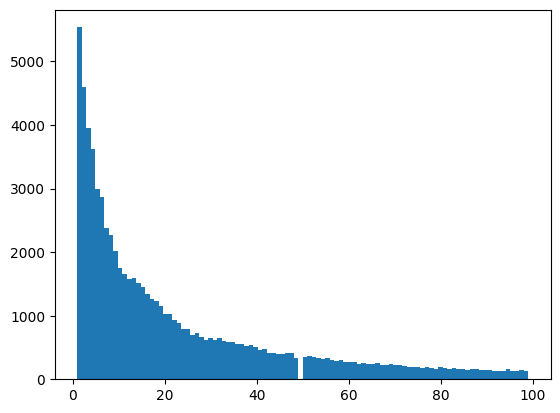

In [87]:
new_df = df.query('sum_gamerounds < 100 and sum_gamerounds > 0')
plt.hist(new_df['sum_gamerounds'], bins=100);


In [70]:
df['version'].value_counts()

gate_40    45489
gate_30    44700
Name: version, dtype: int64

In [58]:
cross_table_1 = pd.crosstab(df['version'], df['retention_1'])


# Выполнение хи-квадрат теста
chi2_statistic, p_value_1, _, _ = chi2_contingency(cross_table_1)

result_1 = 'Принимаем H0' if p_value_1 >= 0.05 else 'Отвергаем H0'
result_1, p_value_1

('Принимаем H0', 0.07550476210309086)

In [57]:
# Создание таблицы сопряженности
cross_table_7 = pd.crosstab(df['version'], df['retention_7'])


# Выполнение хи-квадрат теста
chi2_statistic, p_value_7, _, _ = chi2_contingency(cross_table_7)

result_7 = 'Принимаем H0' if p_value_7 >= 0.05 else 'Отвергаем H0'
result_7, p_value_7

('Отвергаем H0', 0.0016005742679058301)

In [59]:
cross_table_7, cross_table_1

(retention_7  False  True 
 version                  
 gate_30      36198   8502
 gate_40      37210   8279,
 retention_1  False  True 
 version                  
 gate_30      24666  20034
 gate_40      25370  20119)